# Train the EfficientNet model for ML Use Case 3

In this notebook, we delve into the snow covered road dataset. Our goal is to train a model for snow severity classification. Specifically, we will set up data paths, load the dataset, and preprocess the data for training. We will then train the EfficientNet model with adding layers and evaluate its visualize sample predictions to understand the model's performance better.

In [8]:
# import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from pathlib import Path
import timm
from torchvision.transforms import Normalize, Compose, ToPILImage
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Set Up Data Paths

In [2]:
train_dir = Path('../data-collection/Snow-Covered-Roads-Dataset-main/dataset/augmented_train')
test_dir = Path('../data-collection/Snow-Covered-Roads-Dataset-main/dataset/test')

### 2. Load and preprocess the data

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Load the full dataset using ImageFolder and apply the data transformations
full_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)

# Calculate the sizes for the training and validation datasets (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the full dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# Load the test dataset using ImageFolder and apply the same data transformations
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

# Create DataLoader objects for the training, validation, and test datasets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = full_dataset.classes


### 3. Define the model

In [5]:
class EfficientNetModel(nn.Module):
    def __init__(self):
        super(EfficientNetModel, self).__init__()
        # Load the pretrained EfficientNet-B0 model
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        # Replace the classifier layer with a new fully connected layer of size 512
        self.efficientnet.classifier = nn.Linear(self.efficientnet.classifier.in_features, 512)
        
        # Additional layers
        self.fc1 = nn.Linear(512, 256)  # Additional layer
        self.fc2 = nn.Linear(256, 128)  # Additional layer
        self.fc3 = nn.Linear(128, len(class_names))  # Final layer for classification
        
        # Activation function and dropout layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, image):
        # Forward pass through the EfficientNet model
        x = self.efficientnet(image)
        # Forward pass through additional layers with ReLU activation and dropout
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))  # Additional layer
        x = self.fc3(x)
        return x


In [9]:
# Instantiate the model and move it to the appropriate device
model = EfficientNetModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function, the optimizer, and the scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

### 4. Model Training

In [10]:
num_epochs = 50
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    print(f"Epoch [{epoch+1}/{num_epochs}] starting...")  # Debug information
    for i, (images, labels) in enumerate(dataloaders['train']):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss / (i+1)}") 

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloaders['train'])}")
    scheduler.step()
    
    # Validation accuracy check
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(dataloaders['val'])
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, 'snow_best_efficientnet_model.pth')

print("Finished Training")

Epoch [1/50] starting...
[1, 100] loss: 0.8239071330428124
[1, 200] loss: 0.7256806150078774
[1, 300] loss: 0.6855078903834025
[1, 400] loss: 0.6439495305344463
[1, 500] loss: 0.6133001871705055
[1, 600] loss: 0.5973695700863997
[1, 700] loss: 0.5749513573944569
[1, 800] loss: 0.5586014799587429
[1, 900] loss: 0.5437464125951131
[1, 1000] loss: 0.5291756526827812
[1, 1100] loss: 0.5201378238268873
[1, 1200] loss: 0.5110823423850039
[1, 1300] loss: 0.5049930732697249
Epoch [1/50], Loss: 0.509496186683863
Validation Loss: 0.3306869208222119, Validation Accuracy: 85.71020019065777%
Epoch [2/50] starting...
[2, 100] loss: 0.47245214857161044
[2, 200] loss: 0.4055865093320608
[2, 300] loss: 0.3747796259820461
[2, 400] loss: 0.36496034752577544
[2, 500] loss: 0.3545292327404022
[2, 600] loss: 0.35002749644219877
[2, 700] loss: 0.3444682608864137
[2, 800] loss: 0.3368438087776303
[2, 900] loss: 0.33224263419707617
[2, 1000] loss: 0.3284623976536095
[2, 1100] loss: 0.3230635686421936
[2, 1200]

KeyboardInterrupt: 

### 5. Model Evaluation

In [11]:
model.load_state_dict(torch.load('snow_best_efficientnet_model.pth', map_location=device))

<All keys matched successfully>

Accuracy: 97.06%
Classification Report:
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00      4041
       light       0.89      0.90      0.89       924
      medium       0.97      0.96      0.97      3029
      plowed       0.95      0.94      0.94       739

    accuracy                           0.97      8733
   macro avg       0.95      0.95      0.95      8733
weighted avg       0.97      0.97      0.97      8733

Confusion Matrix:


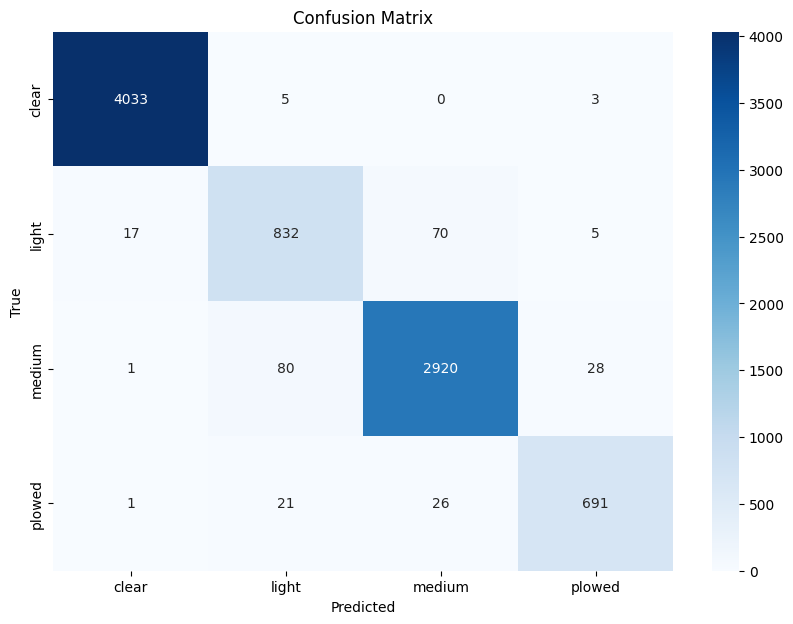

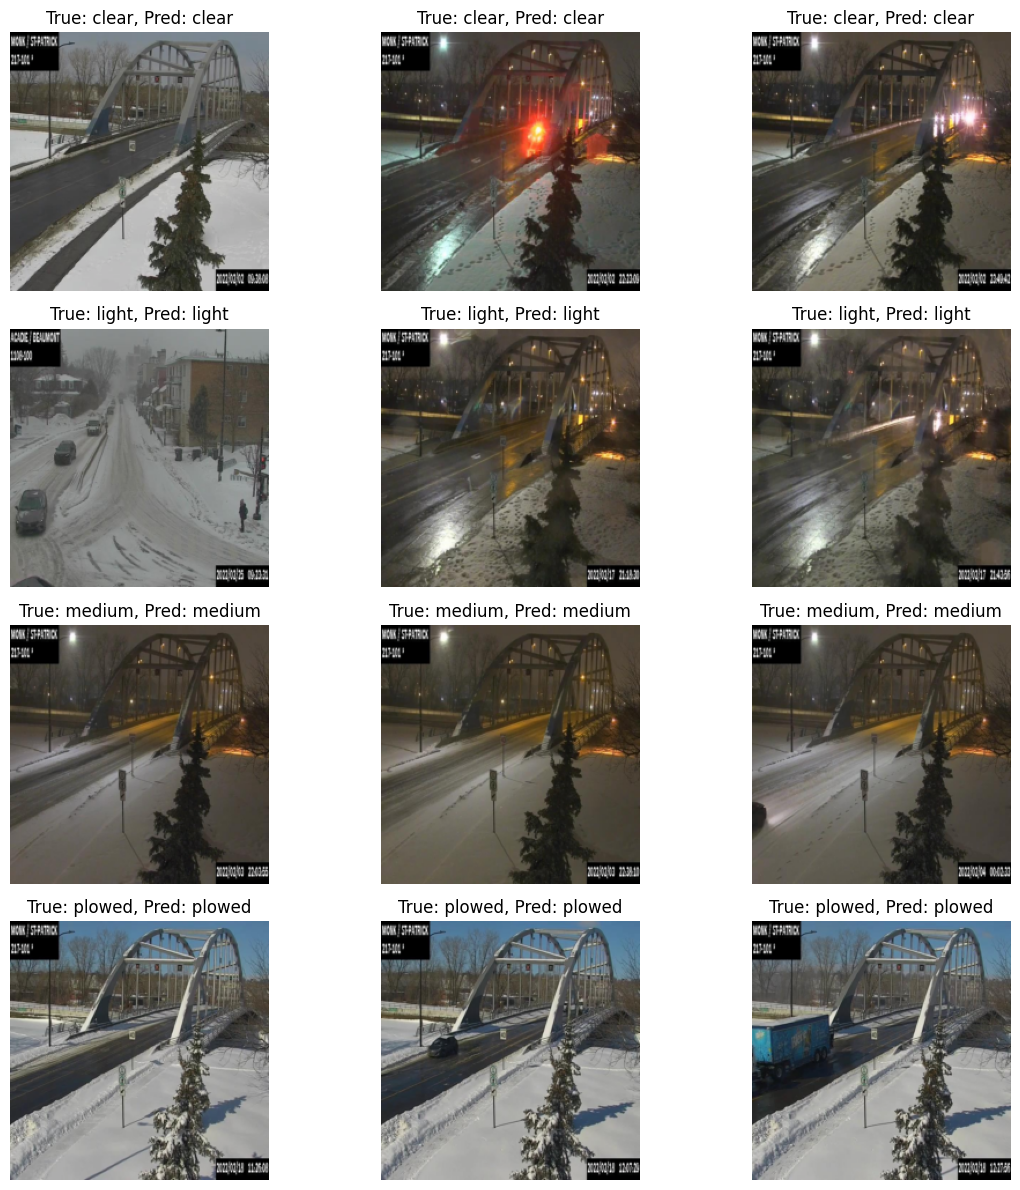

In [12]:
all_preds = []
all_labels = []

model.eval()
# Evaluate the model
with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Define inverse normalization
inv_normalize = Compose([
    Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
])

# Display two sample images for each label
samples_per_label = 3

# Initialize a dictionary to store sample counts for each label
sample_counts = {label: 0 for label in range(len(class_names))}

# Initialize a figure for plotting
fig, axes = plt.subplots(len(class_names), samples_per_label, figsize=(12, 12))

# Set the model to evaluation mode
model.eval()

# Iterate through the test data
with torch.no_grad():
    sample_plotted = {label: 0 for label in range(len(class_names))}
    for images, labels in dataloaders['test']:
        if all(count == samples_per_label for count in sample_plotted.values()):
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for j in range(len(images)):
            true_label = labels[j].item()
            if sample_plotted[true_label] < samples_per_label:
                ax = axes[true_label, sample_plotted[true_label]]
                image = inv_normalize(images[j].cpu())
                image = ToPILImage()(image)
                ax.imshow(image)
                ax.set_title(f"True: {class_names[true_label]}, Pred: {class_names[preds[j].item()]}")
                ax.axis('off')
                sample_plotted[true_label] += 1

# Adjust layout
plt.tight_layout()
plt.show()